In [ ]:
from torch import tensor
from torchvision import transforms
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
import logging
import math
import random
from sklearn.mixture import GaussianMixture
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import kstest, anderson_ksamp, cumfreq, ks_2samp, cramervonmises, chisquare, entropy, wasserstein_distance
from keras import datasets, models, layers, optimizers
from keras.datasets import mnist, cifar10
from torch import from_numpy
from keras.utils import plot_model

In [ ]:
# train, test = mnist.load_data()

In [ ]:
def get_data(dataset_type, path=None):
    
    if dataset_type == "MNIST":
        train, test = mnist.load_data()
    elif dataset_type == "CIFAR10":
        train, test = cifar10.load_data()
        
    train_x, train_y = from_numpy(train[0]), from_numpy(train[1])
    test_x, test_y = from_numpy(test[0]), from_numpy(test[1])
    train, test = (train_x, train_y), (test_x, test_y)
        
    return train, test

In [ ]:
# train, test = get_data("MNIST", "D:/datasets")

In [ ]:
def log_class_counts(y_train, subset_ID_map, log=False):
    cls_counts = {}

    for subset_i, ID in subset_ID_map.items():
        unq, unq_cnt = np.unique(y_train[ID], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        cls_counts[subset_i] = tmp

    if log:
        logging.debug('Label distributions: %s' % str(cls_counts))

    return cls_counts

In [ ]:
def map_to_prob(y_train, subset_map):
    counts = log_class_counts(y_train, subset_map)

    values = [np.array([counts.get(k).get(key) for key in counts.get(k)]) for k in counts]
    probs = [values[j] / values[j].sum() for j in range(len(values))]

    return probs

In [ ]:
def partition_homo_skf(train, n_clients, alpha=0):
    subset_ID_map = {}
    x_train, y_train = train[0], train[1]
    # n_train = y_train.shape[0]
    skf = StratifiedKFold(n_splits=n_clients, shuffle=True, random_state=42)
    subsets = []
    for train_ID, test_ID in skf.split(train, y_train):
        subsets.append(test_ID)
    for j in range(n_clients):
        # np.random.shuffle(subsets[j])
        subset_ID_map[j] = subsets[j]
    return subset_ID_map

In [ ]:
def partition_hetero_dir(train, n_clients, alpha):
    x_train, y_train = train[0], train[1]
    
    min_size = 0
    # classes
    K = len(y_train.unique())
    # data points
    N = y_train.shape[0]
    subset_ID_map = {}

    while min_size < 10:
        subset_ID_list = [[] for _ in range(n_clients)]
        for k in range(K):
            ids_k = np.where(y_train == k)[0]
            np.random.shuffle(ids_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_clients))
            proportions = np.array(
                [p * (len(ids_j) < N / n_clients) for p, ids_j in zip(proportions, subset_ID_list)])
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(ids_k)).astype(int)[:-1]
            subset_ID_list = [ids_j + ids.tolist() for ids_j, ids in
                              zip(subset_ID_list, np.split(ids_k, proportions))]
            min_size = min([len(ids_j) for ids_j in subset_ID_list])

    for j in range(n_clients):
        np.random.shuffle(subset_ID_list[j])
        subset_ID_map[j] = subset_ID_list[j]

    return subset_ID_map

In [ ]:
def partition_hetero_gaussian(train, n_clients, alpha, bootstrap=False):
    x_train, y_train = train[0], train[1]
    min_size = 0
    # classes
    K = len(set(y_train.tolist()))
    # data points
    N = y_train.shape[0]
    subset_ID_map = {}

    def gaussian_pdf(x, mu, sig):
        return np.exp(- np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (sig * math.sqrt(2 * math.pi))

    labels = list(set(y_train.tolist()))
    mu = 5
    sig = alpha
    proportions = np.array([gaussian_pdf(x, mu, sig) for x in labels])

    if bootstrap:
        # make sure the most frequent label always gets selected
        norm_const = 1 / max(proportions)
        proportions = [item * norm_const for item in proportions]
        prob_map = {labels[i]: proportions[i] for i in range(len(labels))}

        def shuffle_labels(map):
            max_item = max(map, key=map.get)
            max_val = map.get(max_item)
            del map[max_item]
            keys = list(map.keys())
            values = list(map.values())
            random.shuffle(values)
            new_map = {keys[i]: values[i] for i in range(len(keys))}
            new_map.update({max_item:max_val})
            return new_map

        prob_map = shuffle_labels(prob_map)

        subset_ID_list = [[] for _ in range(n_clients)]

        for k in range(K):
            sample = []

            for ID, x in enumerate(y_train.tolist):
                if random.uniform(0, 1) < float(prob_map.get(x)):
                    sample.append(ID)

            subset_ID_list[k] = sample

    else:
        while min_size < 10:
            subset_ID_list = [[] for _ in range(n_clients)]
            for k in range(K):
                ids_k = np.where(y_train == k)[0]
                np.random.shuffle(ids_k)
                proportions = np.array([gaussian_pdf(x, mu, sig) for x in labels])
                proportions = np.array(
                    [p * (len(ids_j) < N / n_clients) for p, ids_j in zip(proportions, subset_ID_list)])
                if proportions.sum()!=0:
                    proportions = proportions / proportions.sum()
                proportions = (np.cumsum(proportions) * len(ids_k)).astype(int)[:-1]
                subset_ID_list = [ids_j + ids.tolist() for ids_j, ids in
                                  zip(subset_ID_list, np.split(ids_k, proportions))]
                min_size = min([len(ids_j) for ids_j in subset_ID_list])

    subset_ID_map = {i: subset_ID_list[i] for i in range(n_clients)}

    return subset_ID_map

In [128]:
def partition_quantity_based(train, n_clients, alpha):
    # sorted = pd.concat([y for x, y in data.groupby(0)]).reset_index().drop(columns=['index'])
    x, y = train[0], train[1]    
    K = len(y.unique())
    # subsets_pure = {i: np.where(y == i)[0] for i in range(10)}
    subsets_pure = np.concatenate([np.where(y == i)[0] for i in range(K)])

    ids = np.arange(y.shape[0])
    batch_ids = np.array_split(ids, n_clients*alpha)
    minibatches = []

    for i in range(n_clients*alpha):
        batch_i = [subsets_pure[j] for j in batch_ids[i]]
        minibatches.append(batch_i)

    minibatches = np.array(minibatches)

    ids_mini = np.random.permutation(range(n_clients*alpha))
    subset_indices = np.array_split(ids_mini, n_clients)

    clients = {}

    for index in subset_indices:
        client_i = []
        for i in index:
            client_i.append(minibatches[i])
        client_i = np.concatenate(client_i)
        clients.update({i:np.array(client_i)})

    return clients


In [129]:
def partition(train, type, n_clients, alpha): 
    partition_funcs = {
        "homo" : partition_homo_skf,
        "hetero-dir": partition_hetero_dir,
        "hetero-gaussian": partition_hetero_gaussian,
        "quant": partition_quantity_based
    }
    
    try:
        partition_func = partition_funcs[type]
    except KeyError:
        raise ValueError(f"Invalid mode: {type}")

    return partition_func(train, n_clients, alpha)

In [130]:
def vis_datasets(path, epoch, y_train, subset_ID_map, mode_plot, mode_partitioning, alpha, save=False):
    counts = log_class_counts(y_train, subset_ID_map)

    values = [np.array([counts.get(k).get(key) for key in counts.get(k)]) for k in counts]
    values_normalized = [values[j] / values[j].sum() for j in range(len(values))]

    n_clients = len(subset_ID_map)

    title_formats = {
        "hetero-dir": "A distribution-based heterogeneous partitioning X~Dir({alpha}) with {n_clients} subsets",
        "hetero-gaussian": "A distribution-based Gaussian heterogeneous partitioning σ={alpha} with {n_clients} subsets",
        "homo": "A homogeneous partitioning with {n_clients} subsets",
    }
    main_title = title_formats.get(mode_partitioning, "")
    main_title = main_title.format(alpha=alpha, n_clients=n_clients)

    subtitle_formats = {
        "hetero_dir": "α_{epoch}={alpha}",
        "hetero-gaussian": "σ_{epoch}={alpha}",
        "homo" : ""
    }

    subtitle = subtitle_formats.get(mode_partitioning, "")
    subtitle = subtitle.format(epoch=epoch, alpha=alpha)

    if mode_plot == "heatmap":
        ax = sns.heatmap(pd.DataFrame(values_normalized), vmin=0, vmax=1, cmap=sns.cm.rocket_r)
        ax.set(xlabel="Labels", ylabel="Clients", title=main_title)
        plt.show()
    elif mode_plot == "histogram":
        dim_x = 2
        dim_y = 5
        K = len(set(y_train.tolist()))
        fig, axes = plt.subplots(dim_y, dim_x)
        # TODO: orient hard-coded values around 'K'
        for j in range(len(values)):
            plt.figure(figsize=(5, 3), dpi=300)
            plt.hist(values[j], [(i - 0.5) / 2 for i in range(2*K)], label="Sampled dist")
            x = np.arange(-0.5, 9.5, 0.1)
            plt.xticks([i for i in range(K)])
            plt.xlabel("Label")
            plt.xlim([-1, 10])
            plt.ylabel("Entries")
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

In [131]:
def tensor_to_csv(x_train, y_train, subset_map, epoch_num):
    for key in subset_map:
        x, y = x_train[subset_map.get(key)], y_train[subset_map.get(key)]
        df_x = pd.DataFrame(x.tolist())
        df_y = pd.DataFrame(y.tolist())
        df_x['targets'] = df_y
        df_x.rename(columns={0: 'data', "targets": "targets"})
        df_x.to_csv(f'subsets/epoch_{epoch_num}_subset_{key + 1}.csv', index=False)

In [132]:
def kl_divergence(p, q):
    return sum(p[i] * math.log2(p[i] / q[i]) for i in range(len(p)) if q[i] != 0 and p[i] != 0)

# Jensen-Shannon Divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

# Gini Coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [133]:
def distance(y_train, subset_map, mode):
    N = y_train.shape[0]
    probs_original, probs = map_to_prob(y_train, {0: np.arange(N)})[0], map_to_prob(y_train, subset_map)
    stats, pvals = [], []

    mode_dict = {
        "kolmogorov-smirnov": lambda x: kstest(x, probs_original),
        "empirical": lambda x: ks_2samp(ECDF(x)(x), ECDF(probs_original)(probs_original)),
        "cramer-von-mises": lambda x: cramervonmises(ECDF(x), ECDF(probs_original)),
        "pearson-chi-squared": lambda x: chisquare(x * N, probs_original * N),
        "anderson-darling": anderson_ksamp
    }
    
    mode_entropy = {
        "kl": lambda x: kl_divergence(x, probs_original),
        "js": lambda x: js_divergence(x, probs_original),
        "wd": lambda x: wasserstein_distance(x, probs_original),
        "gini": gini
    }

    if(mode in mode_entropy):
        try:
            test_func = mode_entropy[mode]
        except KeyError:
            raise ValueError(f"Invalid mode: {mode}")   
            
        stats, pvals = [test_func(probs[j]) for j in range(len(probs))], []
    else:
        try:
            test_func = mode_dict[mode]
        except KeyError:
            raise ValueError(f"Invalid mode: {mode}")
    
        stats, pvals = zip(*[test_func(probs[j]) for j in range(len(probs))])

    return stats, pvals


In [134]:
def run_experiment(dataset_type, alpha_vector, path, mode_part, mode_test, mode_plot, n_clients, plot=False, logpath=None, save=False):
    train, test = get_data(dataset_type, path)
    x_train, y_train, x_test, y_test = train[0], train[1], test[0], test[1]
    evol_stat, evol_pval = [], []

    for j in range(len(alpha_vector)):
        a_j = alpha_vector[j]
        subset_map = partition(train, mode_part, n_clients, a_j)
        if save:
            tensor_to_csv(x_train, y_train, subset_map, j)
        stats, pvals = distance(y_train, subset_map, mode_test)
        mean_teststat_j = np.mean(stats)
        mean_pval_j = np.mean(pvals)
        evol_stat.append(mean_teststat_j)
        evol_pval.append(mean_pval_j)

    title_formats_part = {
        "hetero-dir": "Mean divergence from original distribution under heterogeneous partitioning via Dirichlet distribution",
        "hetero-gaussian": "Mean divergence from original distribution under heterogeneous partitioning via Gaussian distribution",
        "homo": "A homogeneous partitioning with {n_clients} subsets",
        "quant": "A quantity-based heterogeneous partitioning with {n_clients} subsets"
    }

    title_formats_test = {
        "kolmogorov-smirnov": "Test Statistic: Kolmogorov-Smirnov",
        "empirical": "Test Statistic: Empirical Distribution",
        "kl": "Test Statistic: Kullback-Leibler Divergence (Entropy-Based)",
        "js": "Test Statistic: Jensen-Shannon Divergence (Entropy-Based)",
        "wd": "Test Statistic: Wasserstein Distance",
        "gini": "Test Statistic: Gini Coefficient"
    }
    
    main_title = title_formats_part.get(mode_part, "")
    main_title = main_title.format(n_clients=n_clients)
    appendage = title_formats_test.get(mode_test, "")
    main_title = dataset_type +': ' + main_title + '\n' + appendage
    
    if mode_part == "quant":
        l, u = tuple(round(x,1) for x in (min(alpha_vector), max(alpha_vector)))
        xlab = f'[{u}:{l}], set of divisors for {u}' 
    elif len(alpha_vector) <=15:
        xlab = [f'α_{j}={alpha}' for j, alpha in enumerate(alpha_vector)]
    else:
        l, u, steps = tuple(round(x,1) for x in (min(alpha_vector), max(alpha_vector), (max(alpha_vector)-min(alpha_vector))/(len(alpha_vector)-1)))
        xlab = f'[{l}:{u}], step size = {steps}'

    if plot:
        vis_divergence(evol_stat, alpha_vector, mode_plot, main_title, xlab)
    
    return (evol_stat, evol_pval)

In [135]:
def vis_divergence(evol_stat, alphas, mode_plot, main_title, xlab): 
    
    def linplot(stats, alphas):
        plt.figure(figsize=(5, 3), dpi=300)
        plt.plot(alphas, stats)
        plt.xlabel(xlab)
        plt.suptitle(main_title, fontsize='small')
        plt.show()
    
    mode_dict = {
        "lp": linplot
    }
    
    try:
        plot_func = mode_dict[mode_plot]
    except KeyError:
        raise ValueError(f"Invalid mode: {mode}")  
    
    plot_func(evol_stat, alphas)

In [136]:
## drawing tools
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle
from matplotlib.container import ErrorbarContainer

class CombinedHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        line, fill = orig_handle
        p1 = plt.Line2D([xdescent, xdescent + width], [ydescent + height / 2] * 2,
                        linestyle=line.get_linestyle(), color=line.get_color())
        p2 = Rectangle(xy=(xdescent, ydescent), width=width, height=height,
                       fc=fill.get_facecolor()[0], hatch=fill.get_hatch())
        return [p1, p2]

def adjust_yaxis_label_fontsize(ax, ylabel, max_fontsize=12):
    fig_height_inches = ax.get_figure().get_figheight()
    dpi = ax.get_figure().get_dpi()
    fig_height_points = fig_height_inches * dpi
    fontsize = min(max_fontsize, int((fig_height_points / len(ylabel))*0.4))
    ax.set_ylabel(ylabel, fontsize=fontsize)

In [165]:
def multi_plot(dataset_type, alpha_vector, path, mode_part, mode_test, mode_plot, n_clients, runs, 
               drawing_opts = {"logx":False,"scatter":False, "color":"blue"}):
    vals = []
    #pvals = []
    for j in range(runs):
        stats = np.array(run_experiment(dataset_type, alpha_vector, path, mode_part, mode_test, mode_plot, n_clients, plot=False)[0])
        #pval = np.array(run_experiment(dataset_type, alpha_vector, path, mode_part, mode_test, mode_plot, n_clients, plot=False)[1])
        vals.append(stats)
        #pvals.append(pval)
        
    p = pd.DataFrame(vals)    
    #q = pd.DataFrame(pvals) 
    means = []
    stds = []
    errs = []
    #means_pval = []
    #stds_pval = []
    for j in range(p.shape[1]):
        col = np.array(p[j])
        #col_pval = np.array(q[j])
        means.append(col.mean())
        #means_pval.append(col_pval.mean())
        # sigma_j = math.sqrt(sum([math.pow(x - np.array(p[j]).mean(), 2) for x in p[j]])/len(p[j]))
        stds.append(np.array(p[j]).std())
        #stds_pval.append(np.array(q[j]).std())
        errs.append(col.std()/math.sqrt(len(col)))
    means, stds = np.array(means), np.array(stds)
    #means_pval, stds_pval = np.array(means_pval), np.array(stds_pval)
    part_dict = {
        "hetero-dir": "Dirichlet-Partitioning",
        "hetero-gaussian": "Gaussian Partitioning",
        "homo": "Homogeneous Partitioning",
        "quant": "Quantity-based\nHeterogeneous Partitioning"
    }

    test_dict = {
        "kolmogorov-smirnov": "Kolmogorov-Smirnov",
        "empirical": "Empirical Distribution",
        "kl": "Kullback-Leibler Divergence\n(Entropy-Based)",
        "js": "Jensen-Shannon Divergence\n(Entropy-Based)",
        "wd": "Wasserstein Distance",
        "gini": "Gini Coefficient"
    }
    
    main_title = f'Evolution of divergence over {runs} epochs - ' + dataset_type 

    for alpha1_pos in range(len(alpha_vector)):
        print(f"{dataset_type},{str(part_dict[mode_part])}, {test_dict[mode_test]}, alpha: {alpha_vector[alpha1_pos]}, mean: {means[alpha1_pos]}, std: {stds[alpha1_pos]}, err: {errs[alpha1_pos]} ")
    #plt.figure()
    fig, ax = plt.subplots(figsize=(5, 2), dpi=300)
    plot = None
    if drawing_opts["scatter"]: 
        plot = ax.errorbar(alpha_vector, means, stds, 0, mfc=drawing_opts["color"], mec=drawing_opts["color"], ls='', label=str(part_dict[mode_part]))
    else: 
        plot, = ax.plot(alpha_vector, means, color=drawing_opts["color"],label=str(part_dict[mode_part]))
    errorband = ax.fill_between(alpha_vector, means - stds, means + stds,color=drawing_opts["color"], alpha=0.35, ls="")
    
    ax.set_title(main_title, fontsize='small')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(test_dict[mode_test])
    #adjust_yaxis_label_fontsize(ax, test_dict[mode_test])
    if drawing_opts["logx"] : ax.set_xscale("log")
    ax.legend([(plot, errorband)], [str(part_dict[mode_part])], handler_map={tuple: CombinedHandler()})
    ax.set_axisbelow(True)
    ax.set_xscale("log")
    ax.grid(linestyle='-', linewidth=0.5)
    #plt.show()

In [138]:
def getDivs(N):
    factors = {1}
    maxP  = int(N**0.5)
    p,inc = 2,1
    while p <= maxP:
        while N%p==0:
            factors.update([f*p for f in factors])
            N //= p
            maxP = int(N**0.5)
        p,inc = p+inc,2
    if N>1:
        factors.update([f*N for f in factors])
    return sorted(factors)  

In [139]:
rocket = ["#34738f","#122f3d","#be3e2b","#ed8a45","#f6de6c"]

CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.1, mean: 2.188880381823324, std: 0.15673383232419194, err: 0.049563589655136873 
CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.11141913841956341, mean: 1.9686796813404985, std: 0.21860276819603994, err: 0.06912826503173038 
CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.12414224406157832, mean: 2.015648239504179, std: 0.2146790502651355, err: 0.06788747647596026 
CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.1383182187481222, mean: 1.9171158733905862, std: 0.1985499460501418, err: 0.06278700588220004 
CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.1541129676064448, mean: 1.8772718799792139, std: 0.1313402389655313, err: 0.04153343035618761 
CIFAR10,Dirichlet-Partitioning, Kullback-Leibler Divergence
(Entropy-Based), alpha: 0.17171134069992167, me

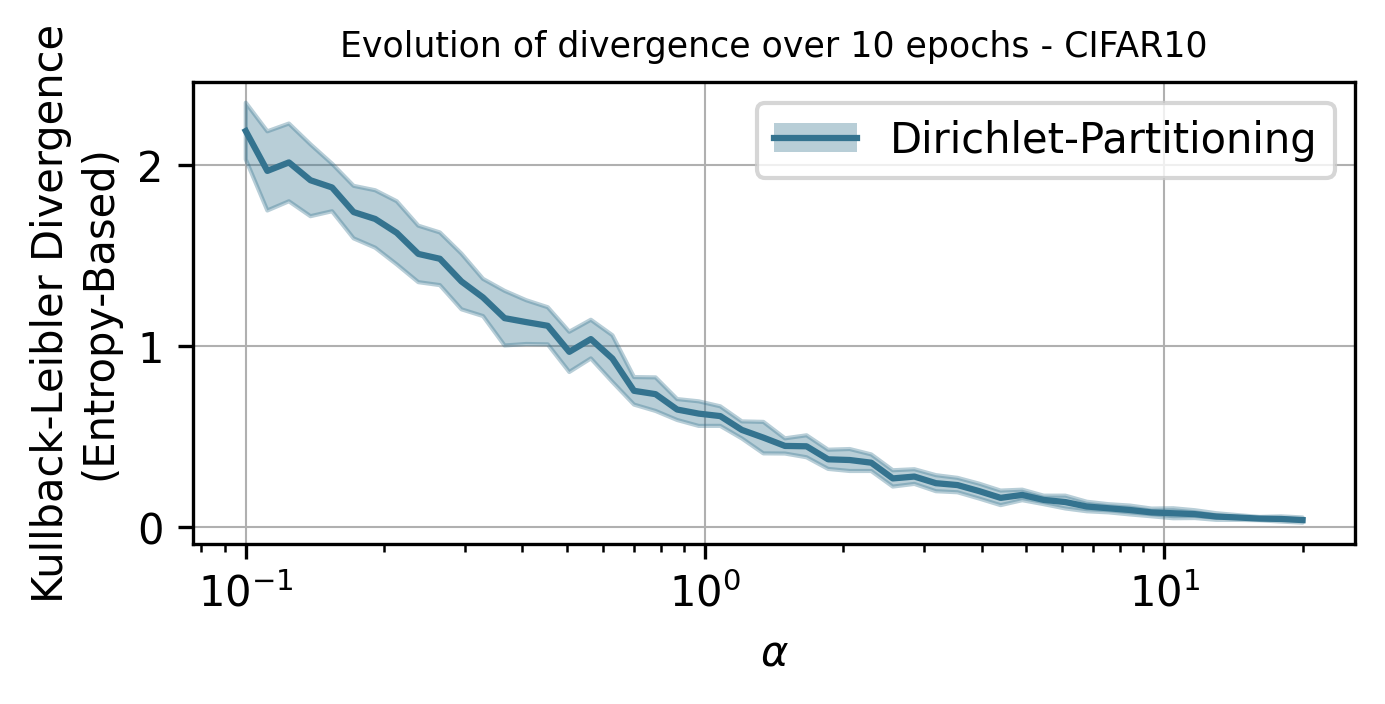

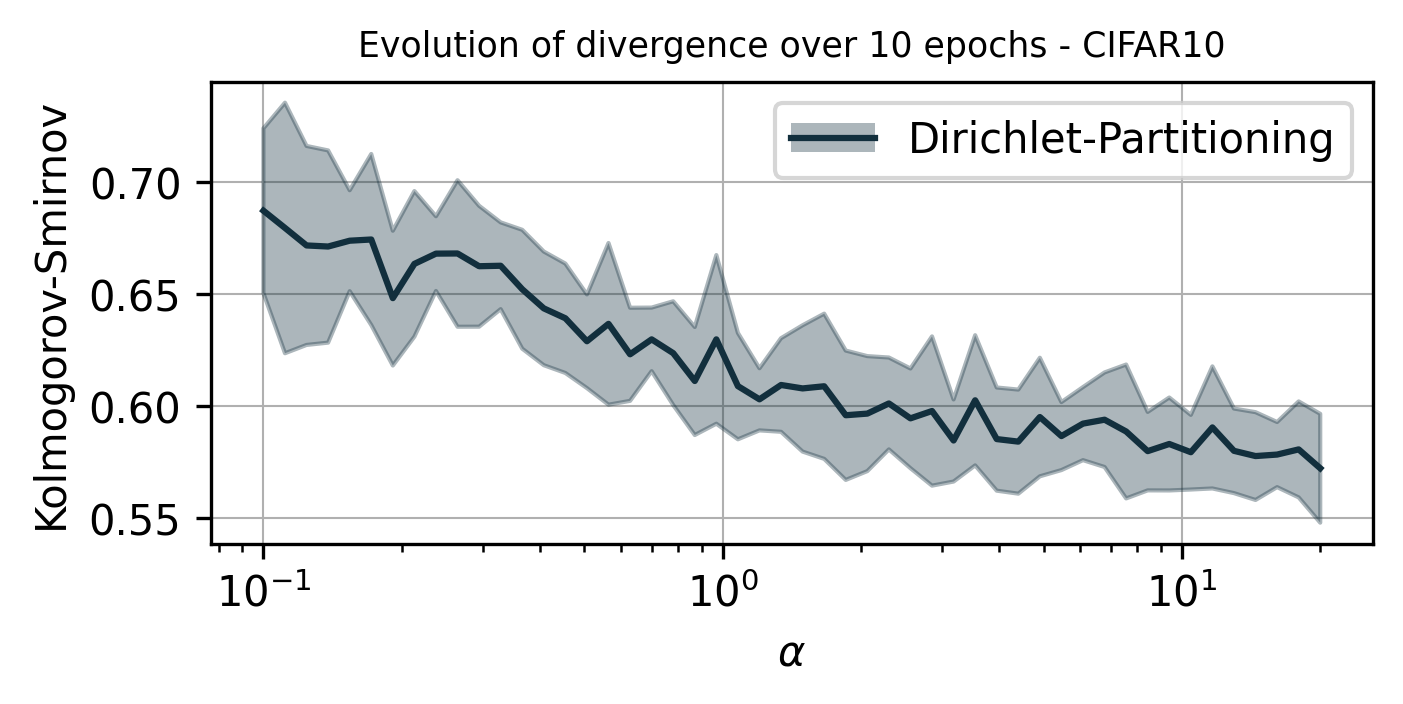

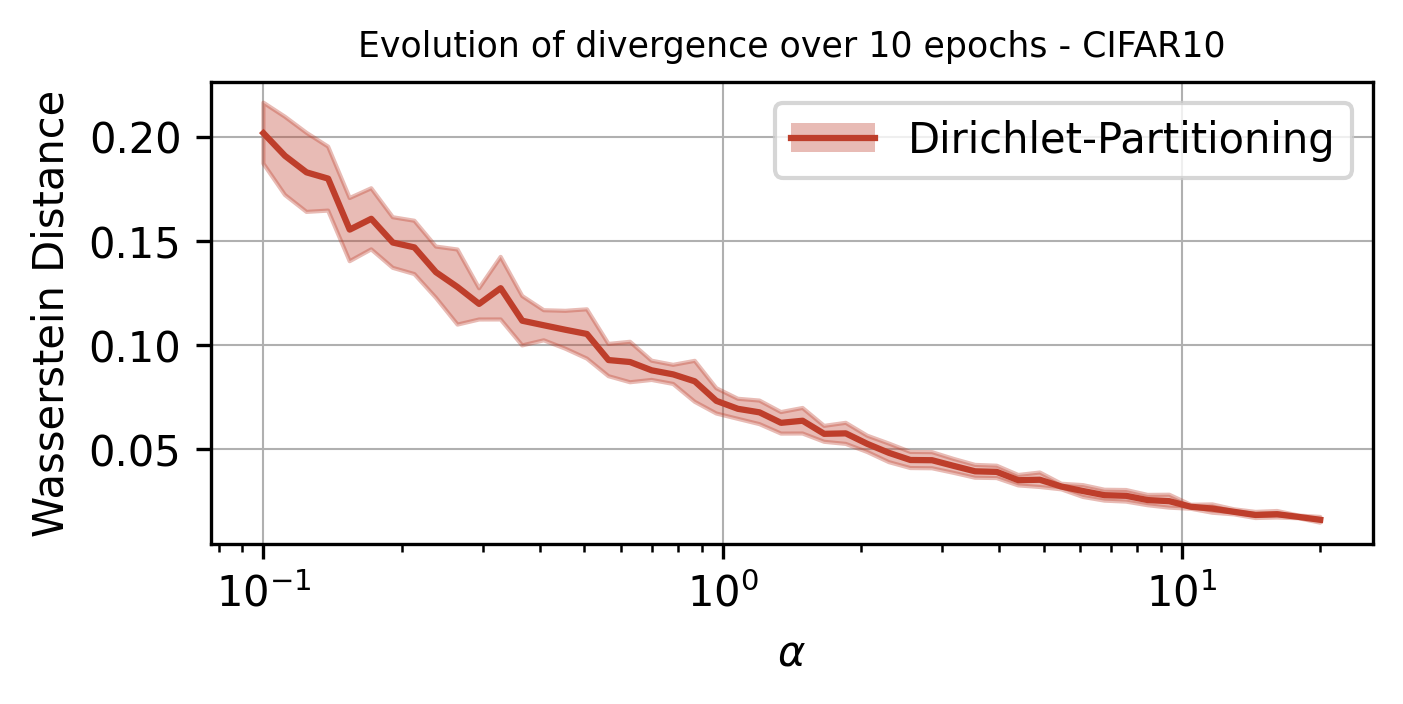

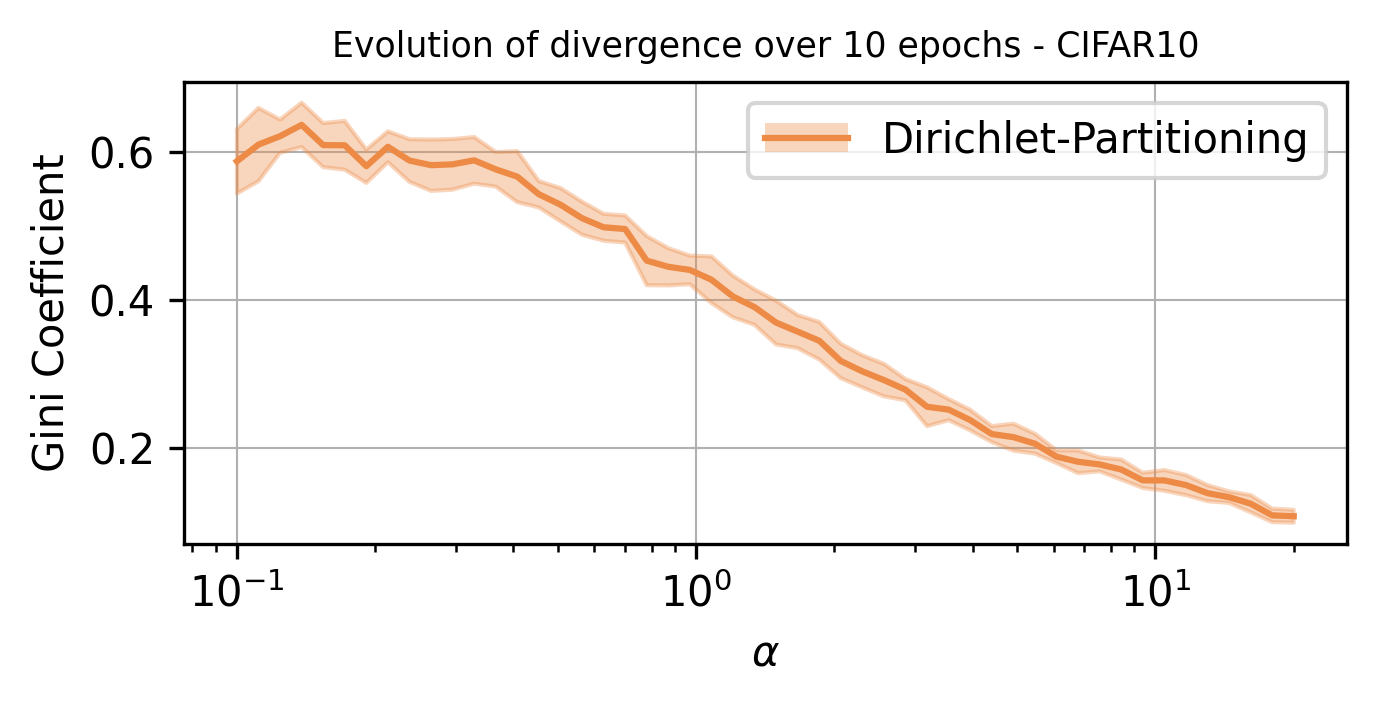

In [167]:
# To run
multi_plot("CIFAR10", np.logspace(-1, 1.30102999566, 50, base=10).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[0]})
multi_plot("CIFAR10", np.logspace(-1, 1.30102999566, 50, base=10).tolist(), "D:/", "hetero-dir", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[1]})
multi_plot("CIFAR10", np.logspace(-1, 1.30102999566, 50, base=10).tolist(), "D:/", "hetero-dir", "wd", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[2]})
multi_plot("CIFAR10", np.logspace(-1, 1.30102999566, 50, base=10).tolist(), "D:/", "hetero-dir", "gini", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[3]})

In [ ]:
CIFAR10 / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.624525164577066, std: 0.07908728343166928, err: 0.025009594959937254 
CIFAR10 / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.6145714285714285, std: 0.023944668044054932, err: 0.007571968883586259 
CIFAR10 / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.07177228431608347, std: 0.0075994183100553956, err: 0.0024031470752162716 
CIFAR10 / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.4172287127601587, std: 0.027343101529067906, err: 0.008646647912508729 
MNIST / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.6909718269139985, std: 0.10058200697336883, err: 0.031806823366678436 
MNIST / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.5996706349206351, std: 0.029601829036614017, err: 0.009360920266260815 
MNIST / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.06956280225674043, std: 0.006213156307570791, err: 0.001964772539056537 
MNIST / hetero-dir: Dirichlet-Partitioning, alpha: 1, mean: 0.4352146986254536, std: 0.0321789785877555, err: 0.010175886511509583 

In [149]:
run_experiment("MNIST", np.arange(0.5, 100.5, 0.5).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, plot=True)
run_experiment("MNIST", getDivs(60000), "D:/", "quant", "kl", "lp", 10, plot=True)
run_experiment("CIFAR10", np.arange(0.5, 100.5, 0.5).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, plot=True)
run_experiment("CIFAR10", getDivs(50000), "D:/", "quant", "kl", "lp", 10, plot=True)

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

9: alpha: 1.0, mean: 0.6427247379033784, std: 0.09149081124865638, err: 0.028931934852230792 


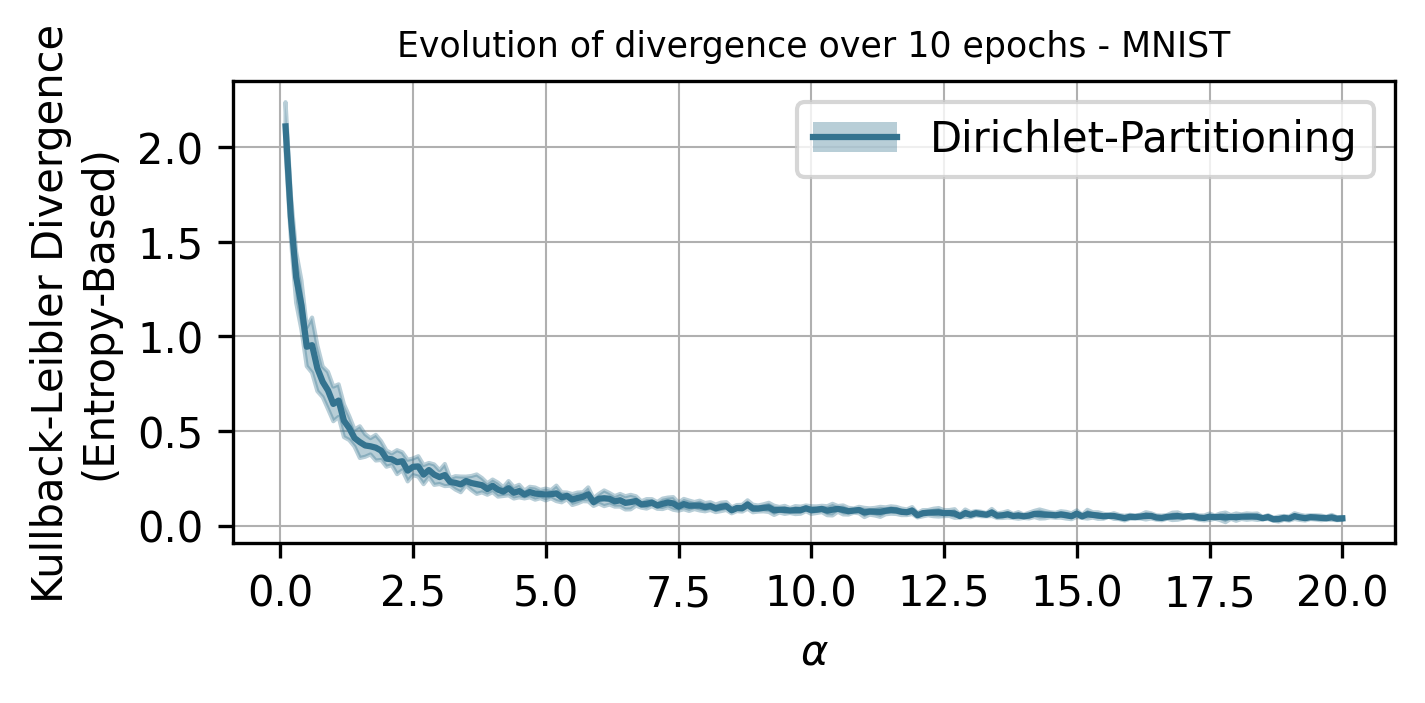

KeyboardInterrupt: 

In [150]:
multi_plot("MNIST", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[0]})
multi_plot("MNIST", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[1]})
multi_plot("MNIST", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "wd", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[2]})
multi_plot("MNIST", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "gini", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[3]})

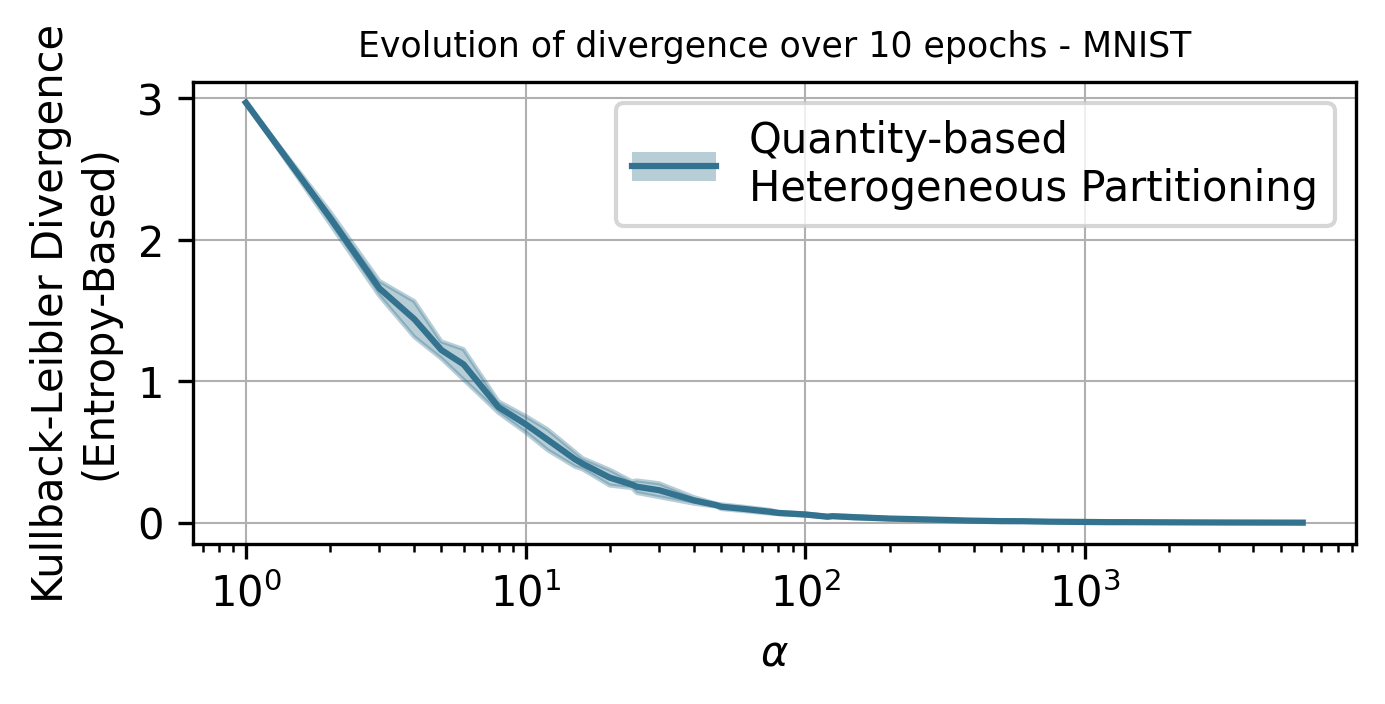

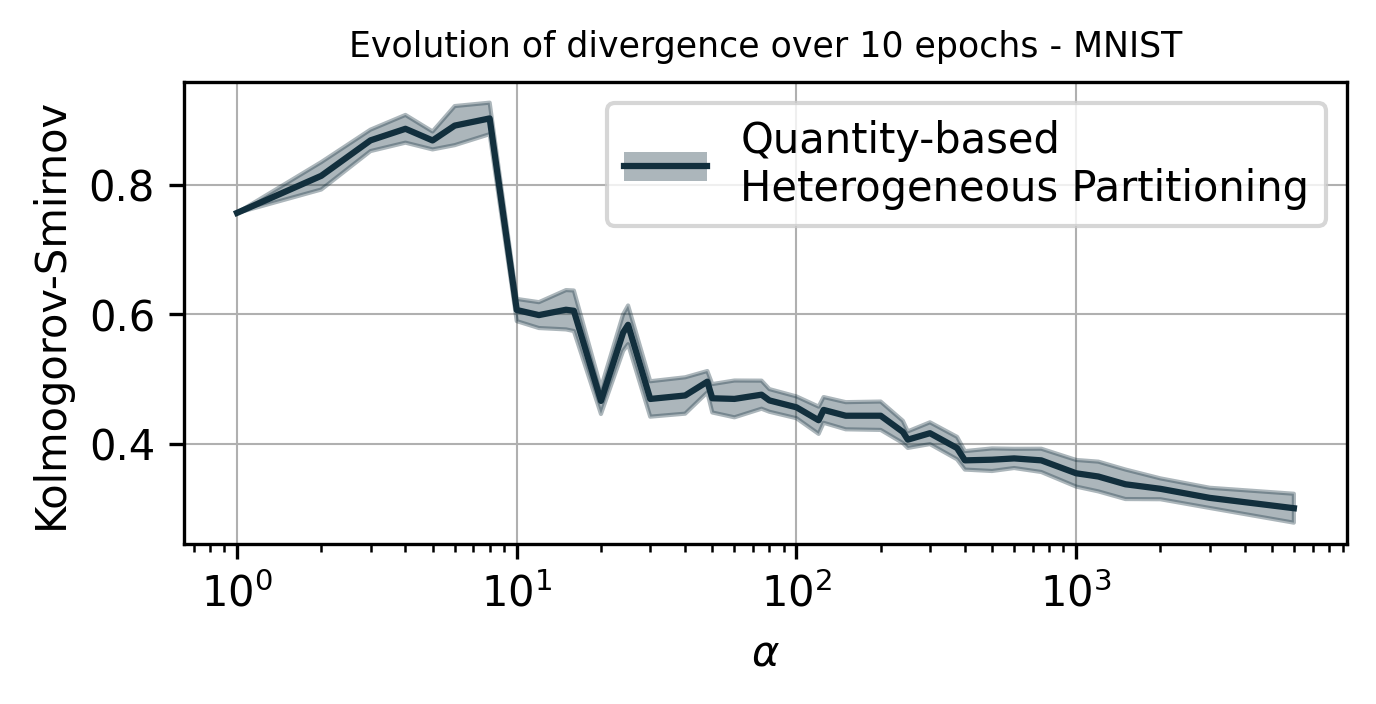

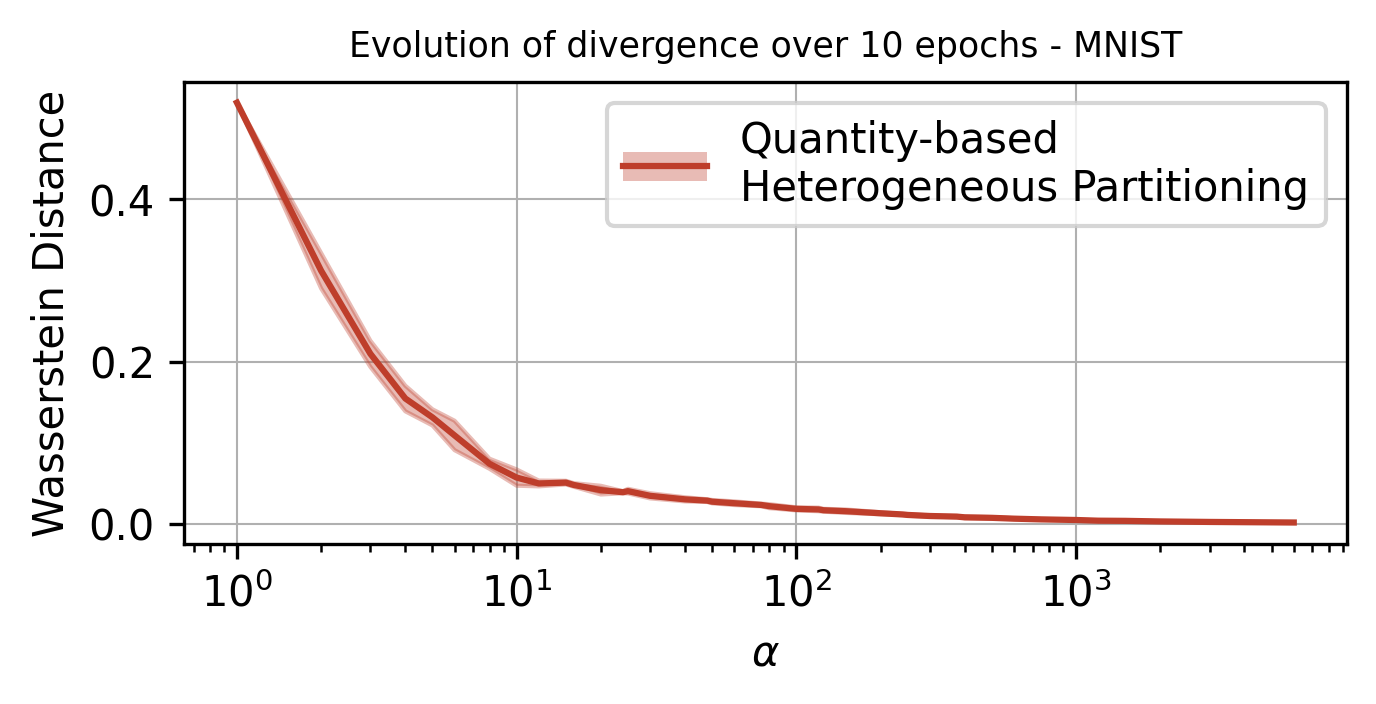

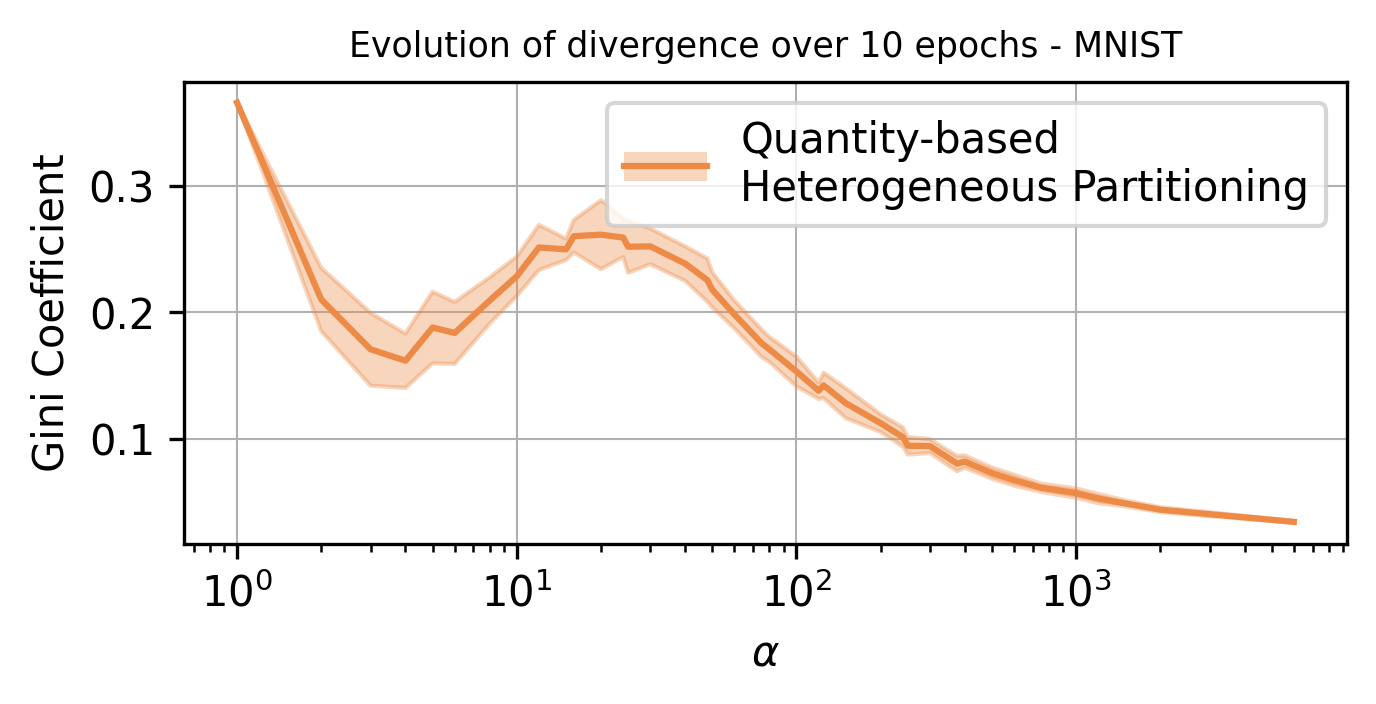

In [142]:
multi_plot("MNIST", getDivs(6000), "D:/", "quant", "kl", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[0]})
multi_plot("MNIST", getDivs(6000), "D:/", "quant", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[1]})
multi_plot("MNIST", getDivs(6000), "D:/", "quant", "wd", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[2]})
multi_plot("MNIST", getDivs(6000), "D:/", "quant", "gini", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[3]})

In [ ]:
multi_plot("CIFAR10", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[0]})
multi_plot("CIFAR10", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[1]})
multi_plot("CIFAR10", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "wd", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[2]})
multi_plot("CIFAR10", np.arange(0.1, 20.1, 0.1).tolist(), "D:/", "hetero-dir", "gini", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[3]})

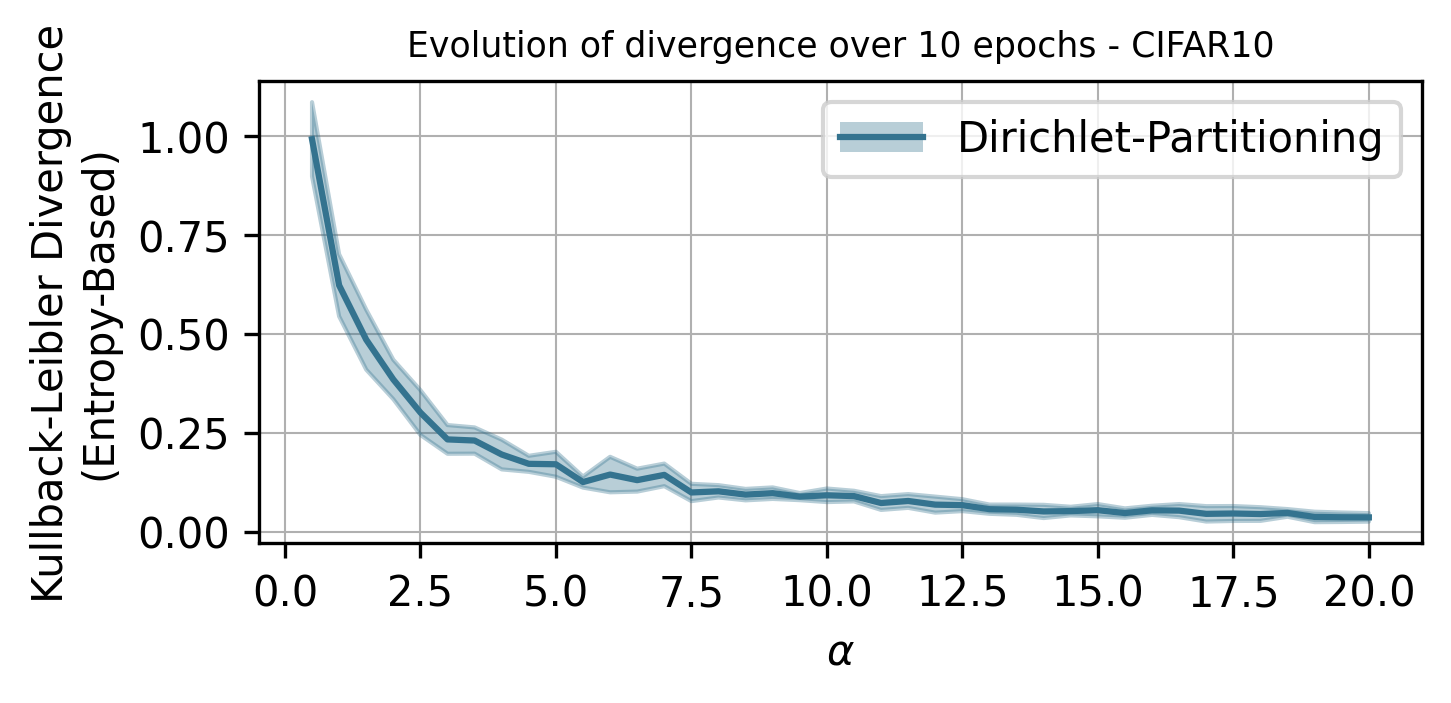

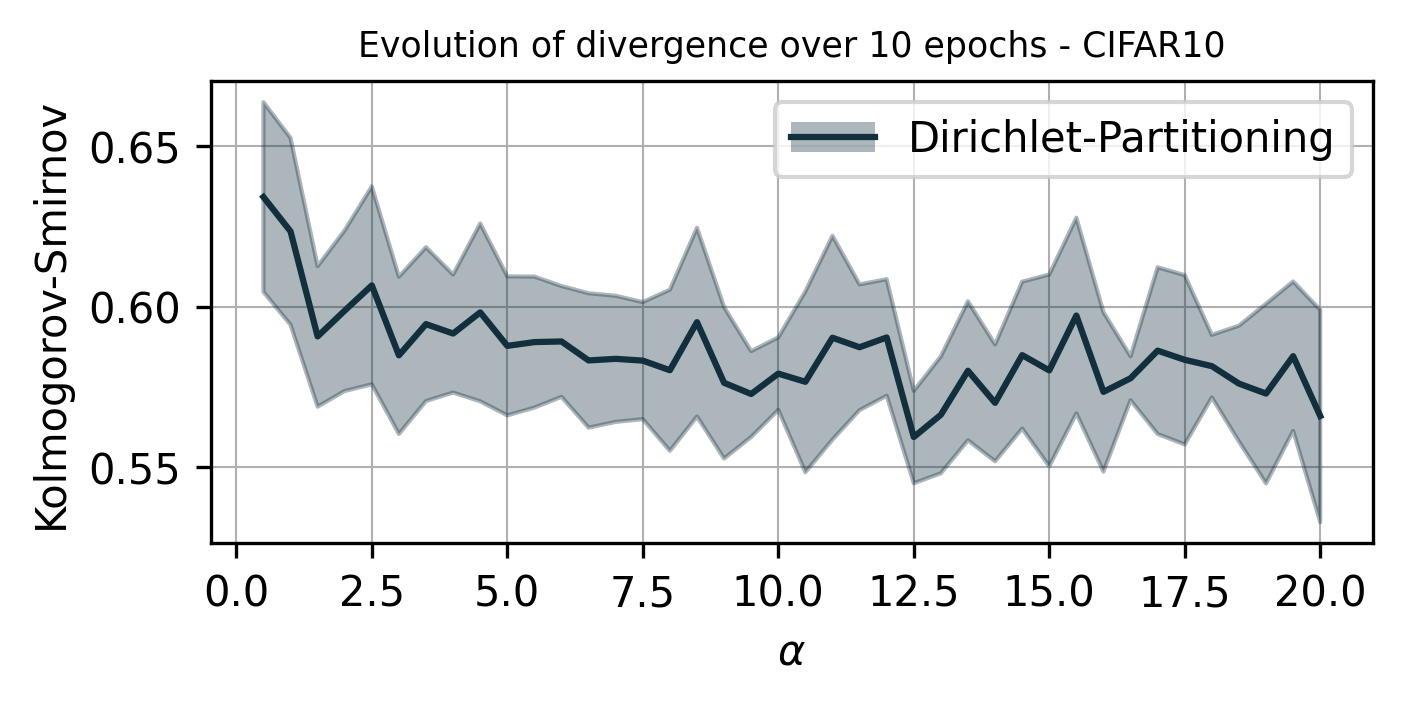

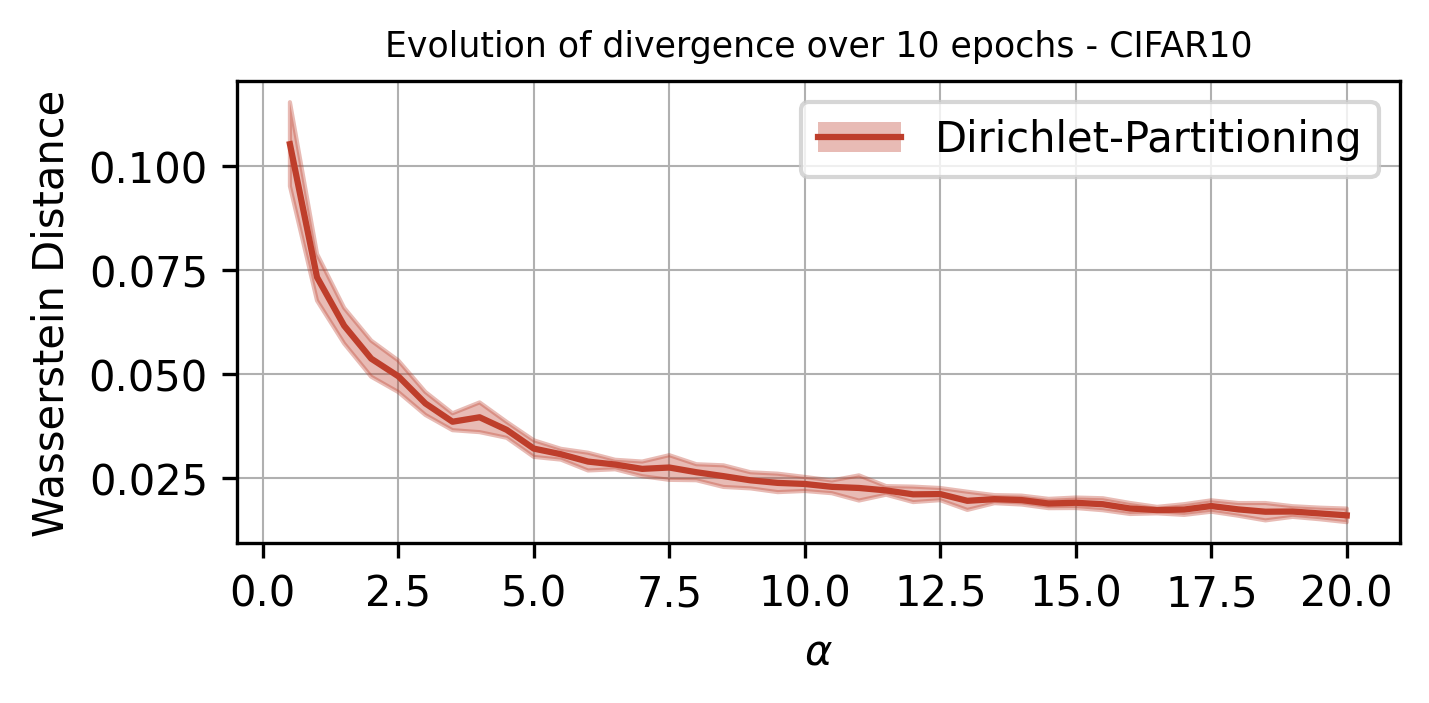

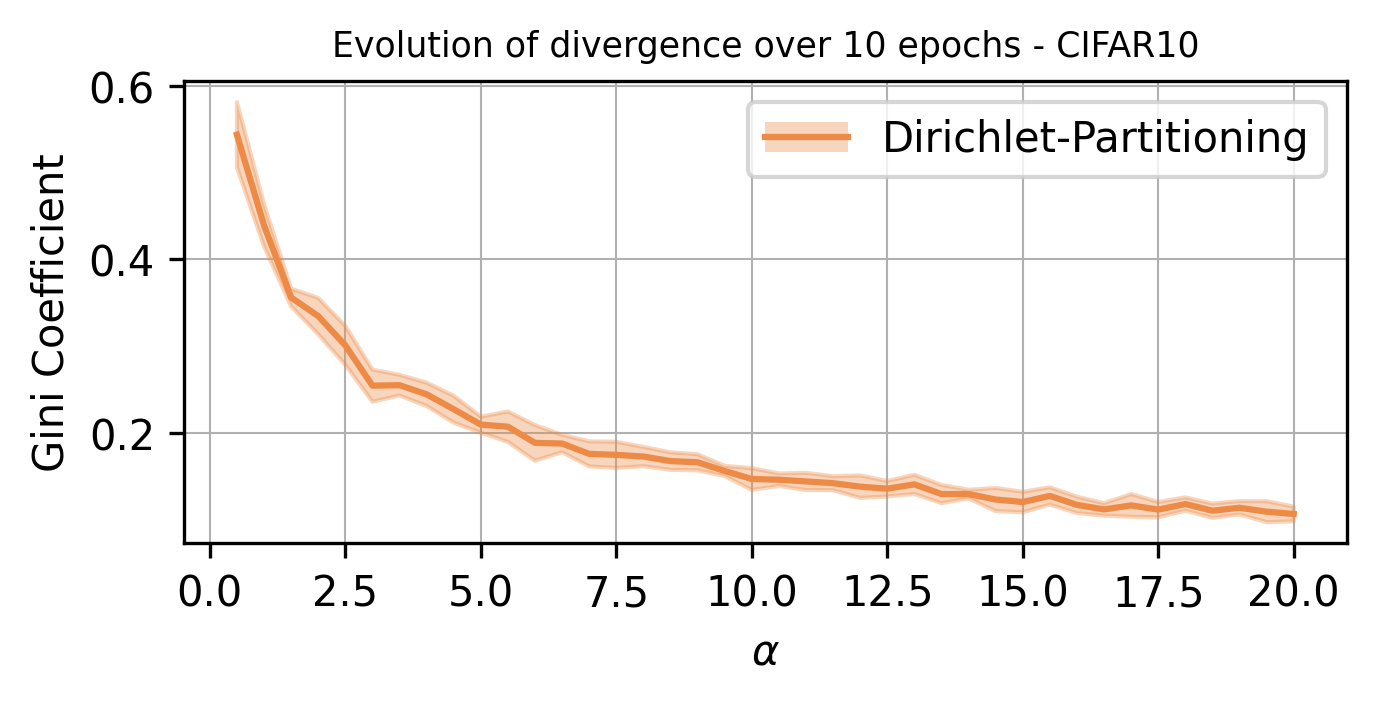

In [143]:
multi_plot("CIFAR10", np.arange(0.5, 20.5, 0.5).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[0]})
multi_plot("CIFAR10", np.arange(0.5, 20.5, 0.5).tolist(), "D:/", "hetero-dir", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[1]})
multi_plot("CIFAR10", np.arange(0.5, 20.5, 0.5).tolist(), "D:/", "hetero-dir", "wd", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[2]})
multi_plot("CIFAR10", np.arange(0.5, 20.5, 0.5).tolist(), "D:/", "hetero-dir", "gini", "lp", 10, 10, drawing_opts={"logx":False,"scatter":False,"color":rocket[3]})
#multi_plot("MNIST", getDivs(60000), "D:/", "quant", "gini", "lp", 10, len(getDivs(10)))
#multi_plot("CIFAR10", np.arange(0.5, 10.5, 0.5).tolist(), "D:/", "hetero-dir", "kl", "lp", 10, 10)
#multi_plot("CIFAR10", getDivs(60000), "D:/", "quant", "kl", "lp", 10, 10)

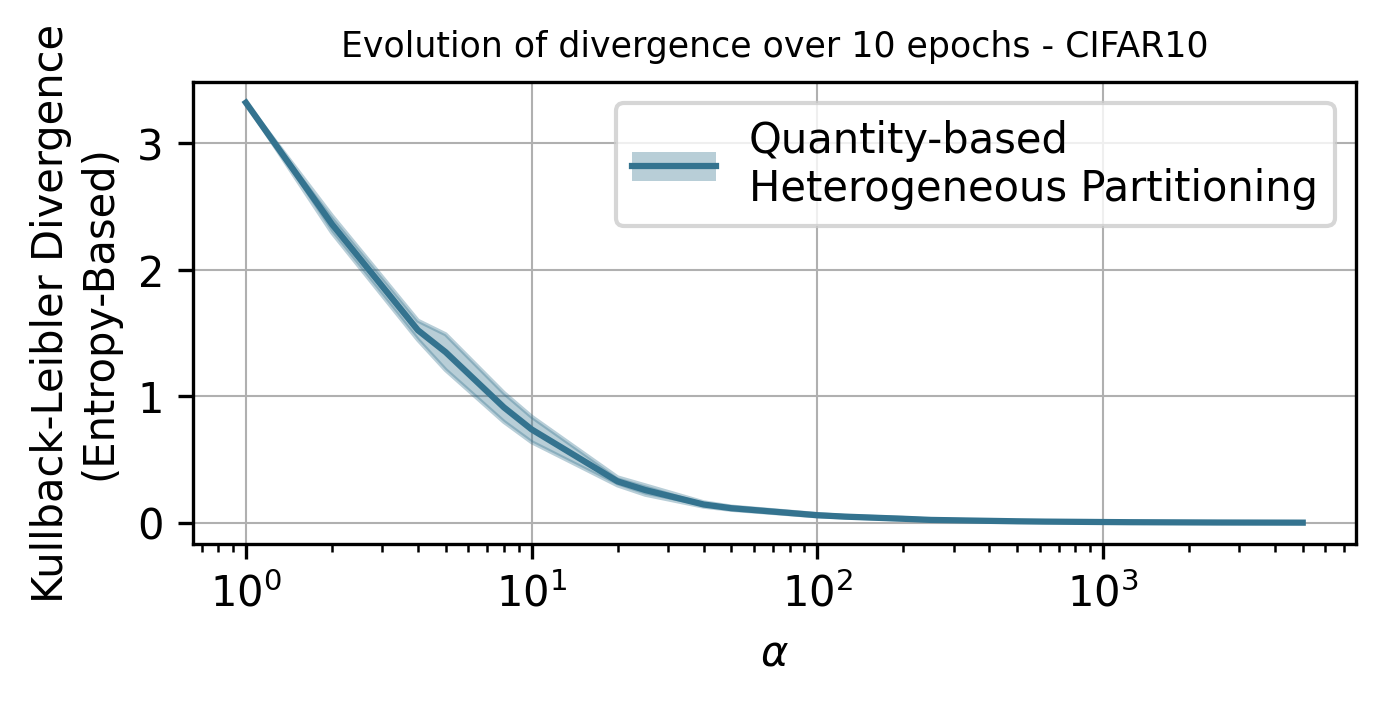

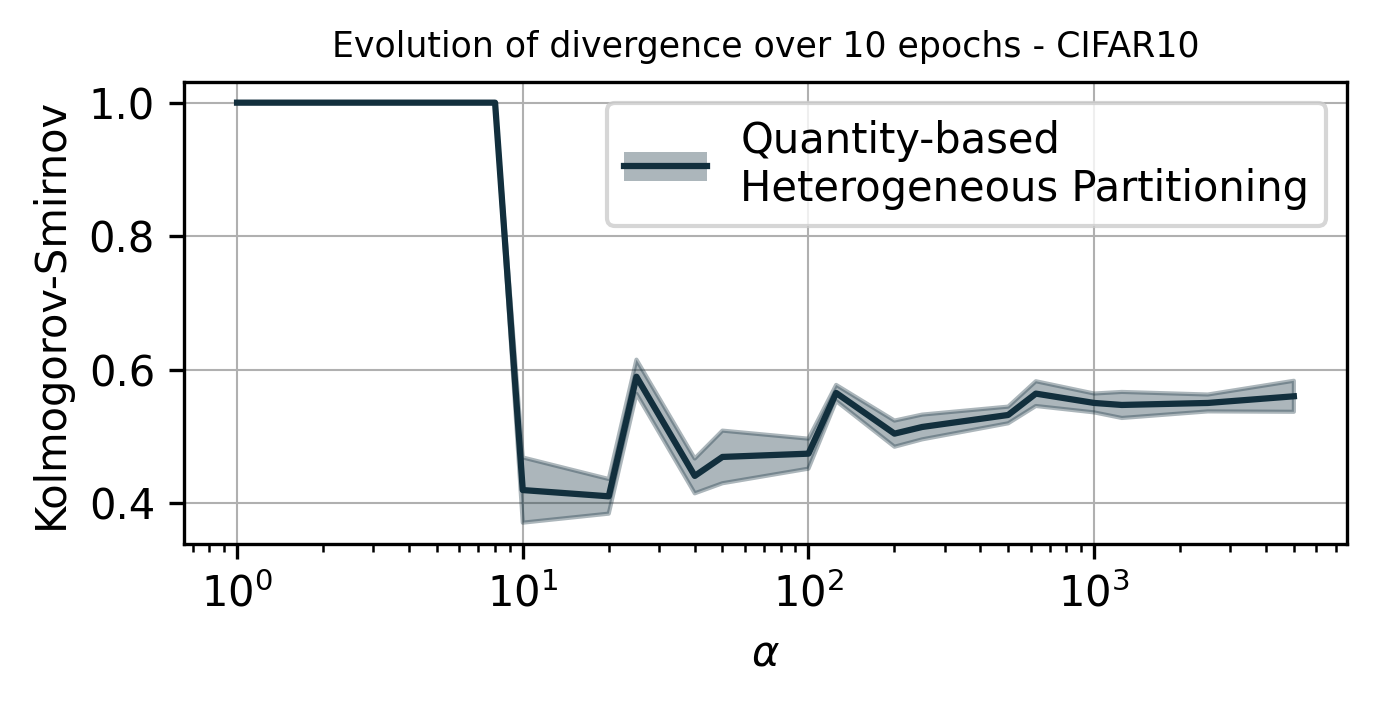

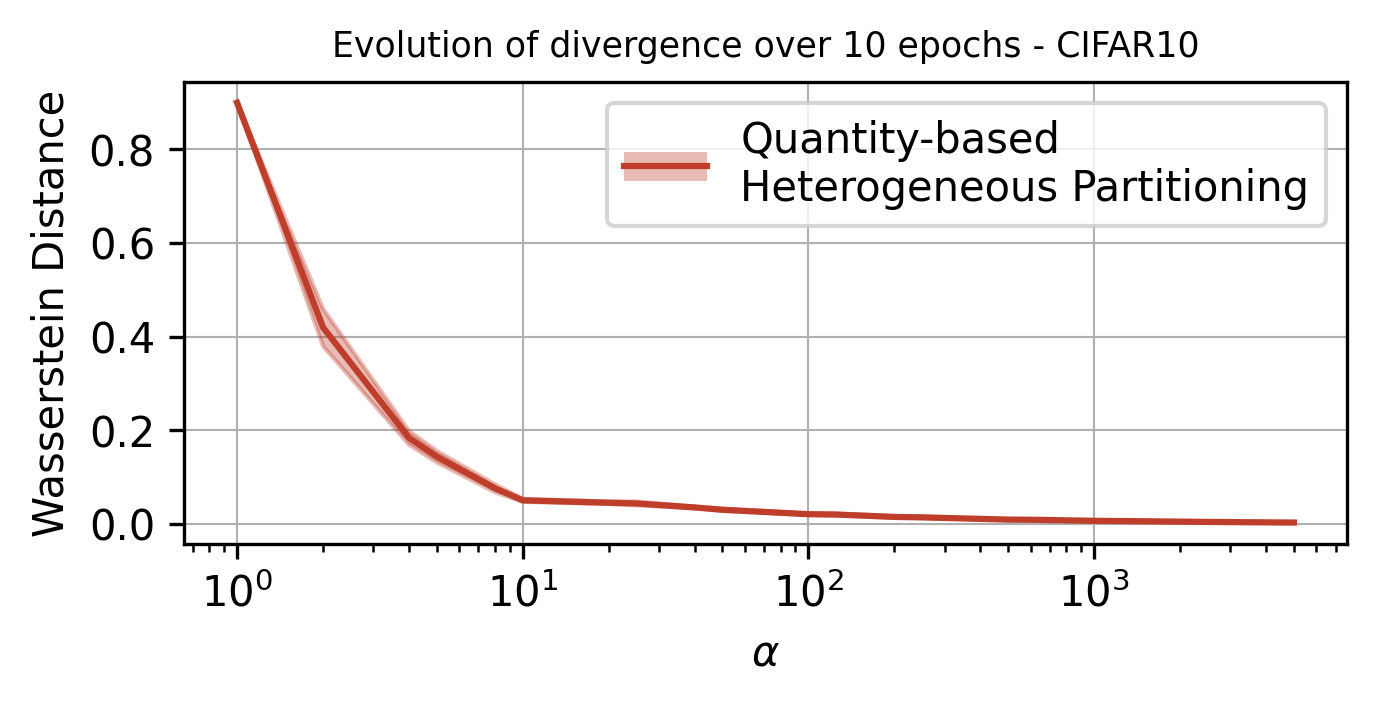

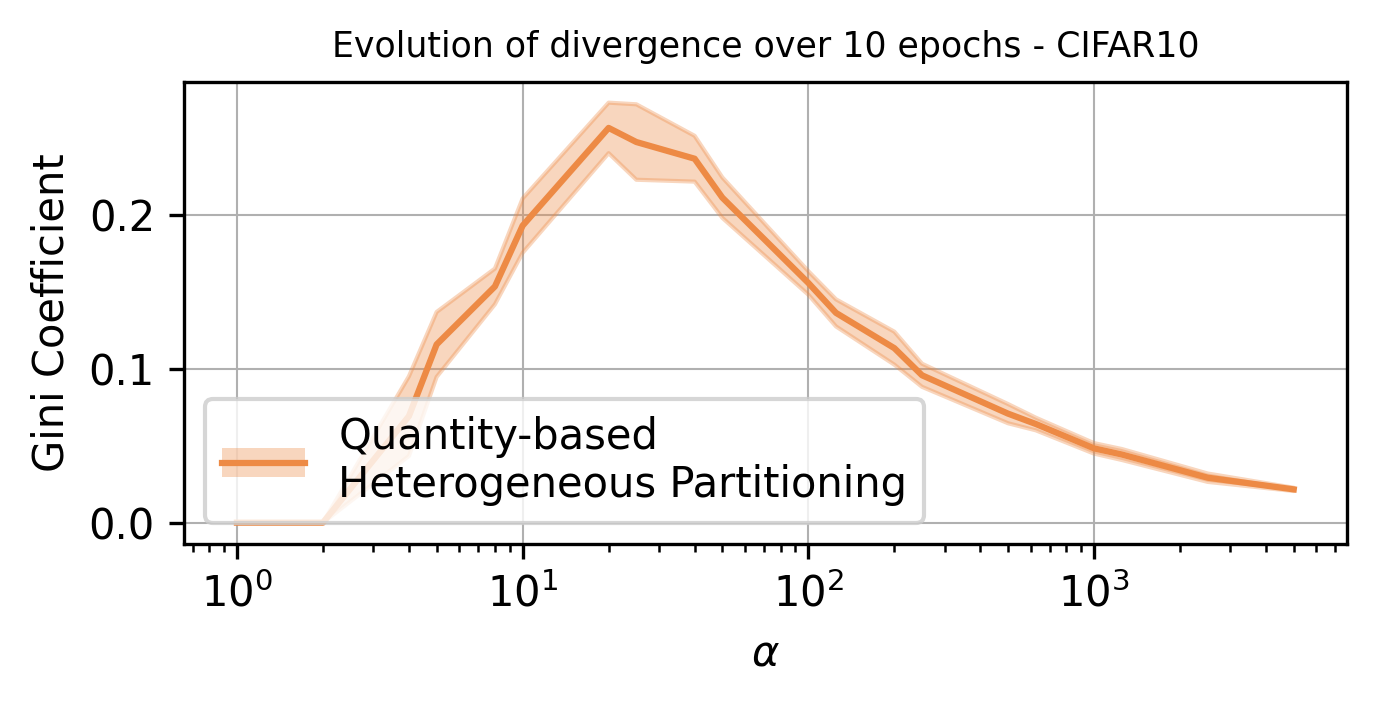

In [144]:
multi_plot("CIFAR10", getDivs(5000), "D:/", "quant", "kl", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[0]})
multi_plot("CIFAR10", getDivs(5000), "D:/", "quant", "kolmogorov-smirnov", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[1]})
multi_plot("CIFAR10", getDivs(5000), "D:/", "quant", "wd", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[2]})
multi_plot("CIFAR10", getDivs(5000), "D:/", "quant", "gini", "lp", 10, 10, drawing_opts={"logx":True,"scatter":False,"color":rocket[3]})